# Image Captioning - Model Training

In this notebook, we will train the image captioning model using the pre-extracted features from the CNN encoder. We will:

1. Set up the data loaders for training and validation
2. Build the caption model (combining the encoder and decoder)
3. Define the training pipeline with teacher forcing
4. Train the model with appropriate hyperparameters
5. Monitor the training progress and validation performance
6. Save the trained model for later evaluation

In [29]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import h5py

# Add project root to path
sys.path.append('..')

# Import project modules
from models.encoder import EncoderCNN
from models.decoder import DecoderRNN
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.trainer import CaptionTrainer

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Configuration Settings

In [3]:
# Define configuration settings
config = {
    # Data settings
    'data_dir': '../data/flickr8k',
    'batch_size': 64,
    'num_workers': 4,
    
    # Model settings
    'encoder_model': 'resnet18',  # Options: 'resnet18', 'resnet50', 'mobilenet_v2'
    'embed_size': 100,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.5,
    'decoder_type': 'lstm',  # Options: 'lstm', 'gru'
    
    # Training settings
    'learning_rate': 3e-4,
    'num_epochs': 15,  # Increase for better results
    'early_stopping_patience': 5,
    'save_dir': '../models',
    
    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create save directory if it doesn't exist
os.makedirs(config['save_dir'], exist_ok=True)

# Print configuration
for section, items in {
    'Data': ['data_dir', 'batch_size', 'num_workers'],
    'Model': ['encoder_model', 'embed_size', 'hidden_size', 'num_layers', 'dropout', 'decoder_type'],
    'Training': ['learning_rate', 'num_epochs', 'early_stopping_patience', 'save_dir'],
    'Device': ['device']
}.items():
    print(f"\n{section} settings:")
    for item in items:
        print(f"  {item}: {config[item]}")


Data settings:
  data_dir: ../data/flickr8k
  batch_size: 64
  num_workers: 4

Model settings:
  encoder_model: resnet18
  embed_size: 100
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm

Training settings:
  learning_rate: 0.0003
  num_epochs: 15
  early_stopping_patience: 5
  save_dir: ../models

Device settings:
  device: cuda


## 2. Load Data

In [9]:
# Get data loaders
train_loader, val_loader, test_loader, vocab = get_data_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# Update vocabulary size in config
config['vocab_size'] = len(vocab)
print(f"Vocabulary size: {config['vocab_size']}")

# Display data loader information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Vocabulary size: 2970
Training batches: 468
Validation batches: 79
Test batches: 5000


## 3. Create Model

In [10]:
# Create caption model
model = CaptionModel(
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    vocab_size=config['vocab_size'],
    num_layers=config['num_layers'],
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=config['dropout'],
    train_encoder=False , # Don't train the encoder (use pre-trained weights)
    vocab=vocab,
    use_glove=True
)

# Print model architecture
print(model)

c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CaptionModel(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batch

In [12]:
# Calculate model size
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    num_of_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_of_trainable_parameters

# Calculate and print model size
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params:,}")

# Calculate encoder and decoder sizes separately
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)
print(f"Encoder parameters: {encoder_params:,} ({encoder_params / num_params * 100:.1f}%)")
print(f"Decoder parameters: {decoder_params:,} ({decoder_params / num_params * 100:.1f}%)")

Number of trainable parameters: 3,181,294
Encoder parameters: 51,500 (1.6%)
Decoder parameters: 3,129,794 (98.4%)


## 4. Train the Model

In [13]:
# Create trainer
trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=config['device'],
    learning_rate=config['learning_rate'],
    model_save_dir=config['save_dir']
)

In [14]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=5  # Generate captions and calculate BLEU every 5 epochs
)

Starting training for 15 epochs...
Training on device: cuda


Epoch 1: 100%|██████████| 468/468 [01:22<00:00,  5.65it/s, batch_loss=4.5971, avg_loss=5.1601]


Epoch 1 - Train Loss: 5.0667


Validating: 100%|██████████| 79/79 [00:35<00:00,  2.21it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 1/15 completed in 137.68s - Train Loss: 5.0667, Val Loss: 4.4479


Epoch 2: 100%|██████████| 468/468 [01:11<00:00,  6.59it/s, batch_loss=4.0133, avg_loss=4.2596]


Epoch 2 - Train Loss: 4.2338


Validating: 100%|██████████| 79/79 [00:30<00:00,  2.56it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 2/15 completed in 120.88s - Train Loss: 4.2338, Val Loss: 4.0326


Epoch 3: 100%|██████████| 468/468 [01:12<00:00,  6.47it/s, batch_loss=3.9841, avg_loss=3.9248]


Epoch 3 - Train Loss: 3.9103


Validating: 100%|██████████| 79/79 [00:31<00:00,  2.51it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 3/15 completed in 123.28s - Train Loss: 3.9103, Val Loss: 3.8023


Epoch 4: 100%|██████████| 468/468 [01:10<00:00,  6.62it/s, batch_loss=3.6705, avg_loss=3.7238]


Epoch 4 - Train Loss: 3.7144


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 4/15 completed in 120.38s - Train Loss: 3.7144, Val Loss: 3.6543


Epoch 5: 100%|██████████| 468/468 [01:10<00:00,  6.59it/s, batch_loss=3.4946, avg_loss=3.5831]


Epoch 5 - Train Loss: 3.5735


Validating: 100%|██████████| 79/79 [01:28<00:00,  1.12s/it]


Model checkpoint saved to ../models\best_model_loss.pth
Model checkpoint saved to ../models\best_model_bleu.pth
Epoch 5/15 completed in 177.33s - Train Loss: 3.5735, Val Loss: 3.5596, BLEU-4: 0.0774


Epoch 6: 100%|██████████| 468/468 [01:08<00:00,  6.84it/s, batch_loss=3.4180, avg_loss=3.4787]


Epoch 6 - Train Loss: 3.4742


Validating: 100%|██████████| 79/79 [00:28<00:00,  2.74it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 6/15 completed in 113.90s - Train Loss: 3.4742, Val Loss: 3.4868


Epoch 7: 100%|██████████| 468/468 [01:10<00:00,  6.60it/s, batch_loss=3.4445, avg_loss=3.3951]


Epoch 7 - Train Loss: 3.3897


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 7/15 completed in 116.71s - Train Loss: 3.3897, Val Loss: 3.4331


Epoch 8: 100%|██████████| 468/468 [01:09<00:00,  6.76it/s, batch_loss=3.2912, avg_loss=3.3235]


Epoch 8 - Train Loss: 3.3235


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 8/15 completed in 115.24s - Train Loss: 3.3235, Val Loss: 3.3868


Epoch 9: 100%|██████████| 468/468 [01:11<00:00,  6.50it/s, batch_loss=3.2561, avg_loss=3.2674]


Epoch 9 - Train Loss: 3.2641


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 9/15 completed in 119.21s - Train Loss: 3.2641, Val Loss: 3.3533


Epoch 10: 100%|██████████| 468/468 [01:09<00:00,  6.74it/s, batch_loss=3.0615, avg_loss=3.2163]


Epoch 10 - Train Loss: 3.2134


Validating: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it]


Model checkpoint saved to ../models\best_model_loss.pth
Model checkpoint saved to ../models\best_model_bleu.pth
Epoch 10/15 completed in 174.33s - Train Loss: 3.2134, Val Loss: 3.3210, BLEU-4: 0.0874


Epoch 11: 100%|██████████| 468/468 [01:09<00:00,  6.70it/s, batch_loss=3.1525, avg_loss=3.1678]


Epoch 11 - Train Loss: 3.1669


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 11/15 completed in 116.68s - Train Loss: 3.1669, Val Loss: 3.2929


Epoch 12: 100%|██████████| 468/468 [01:09<00:00,  6.78it/s, batch_loss=3.1067, avg_loss=3.1221]


Epoch 12 - Train Loss: 3.1240


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 12/15 completed in 115.69s - Train Loss: 3.1240, Val Loss: 3.2719


Epoch 13: 100%|██████████| 468/468 [01:10<00:00,  6.67it/s, batch_loss=3.1204, avg_loss=3.0835]


Epoch 13 - Train Loss: 3.0826


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 13/15 completed in 117.50s - Train Loss: 3.0826, Val Loss: 3.2515


Epoch 14: 100%|██████████| 468/468 [01:09<00:00,  6.70it/s, batch_loss=3.1742, avg_loss=3.0471]


Epoch 14 - Train Loss: 3.0492


Validating: 100%|██████████| 79/79 [00:30<00:00,  2.57it/s]


Model checkpoint saved to ../models\best_model_loss.pth
Epoch 14/15 completed in 119.80s - Train Loss: 3.0492, Val Loss: 3.2385


Epoch 15: 100%|██████████| 468/468 [01:08<00:00,  6.79it/s, batch_loss=2.9770, avg_loss=3.0130]


Epoch 15 - Train Loss: 3.0136


Validating: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it]


Model checkpoint saved to ../models\best_model_loss.pth
Model checkpoint saved to ../models\best_model_bleu.pth
Epoch 15/15 completed in 174.18s - Train Loss: 3.0136, Val Loss: 3.2239, BLEU-4: 0.0889
Model checkpoint saved to ../models\final_model.pth
Training completed!
Best validation loss: 3.2239
Best BLEU-4 score: 0.0889


## 5. Analyze Training Results

In [17]:
print(trainer.history['val_bleu'])

[0, 0, 0, 0, 0.07742928052994834, 0, 0, 0, 0, 0.08742421942787519, 0, 0, 0, 0, 0.0888858180277613]


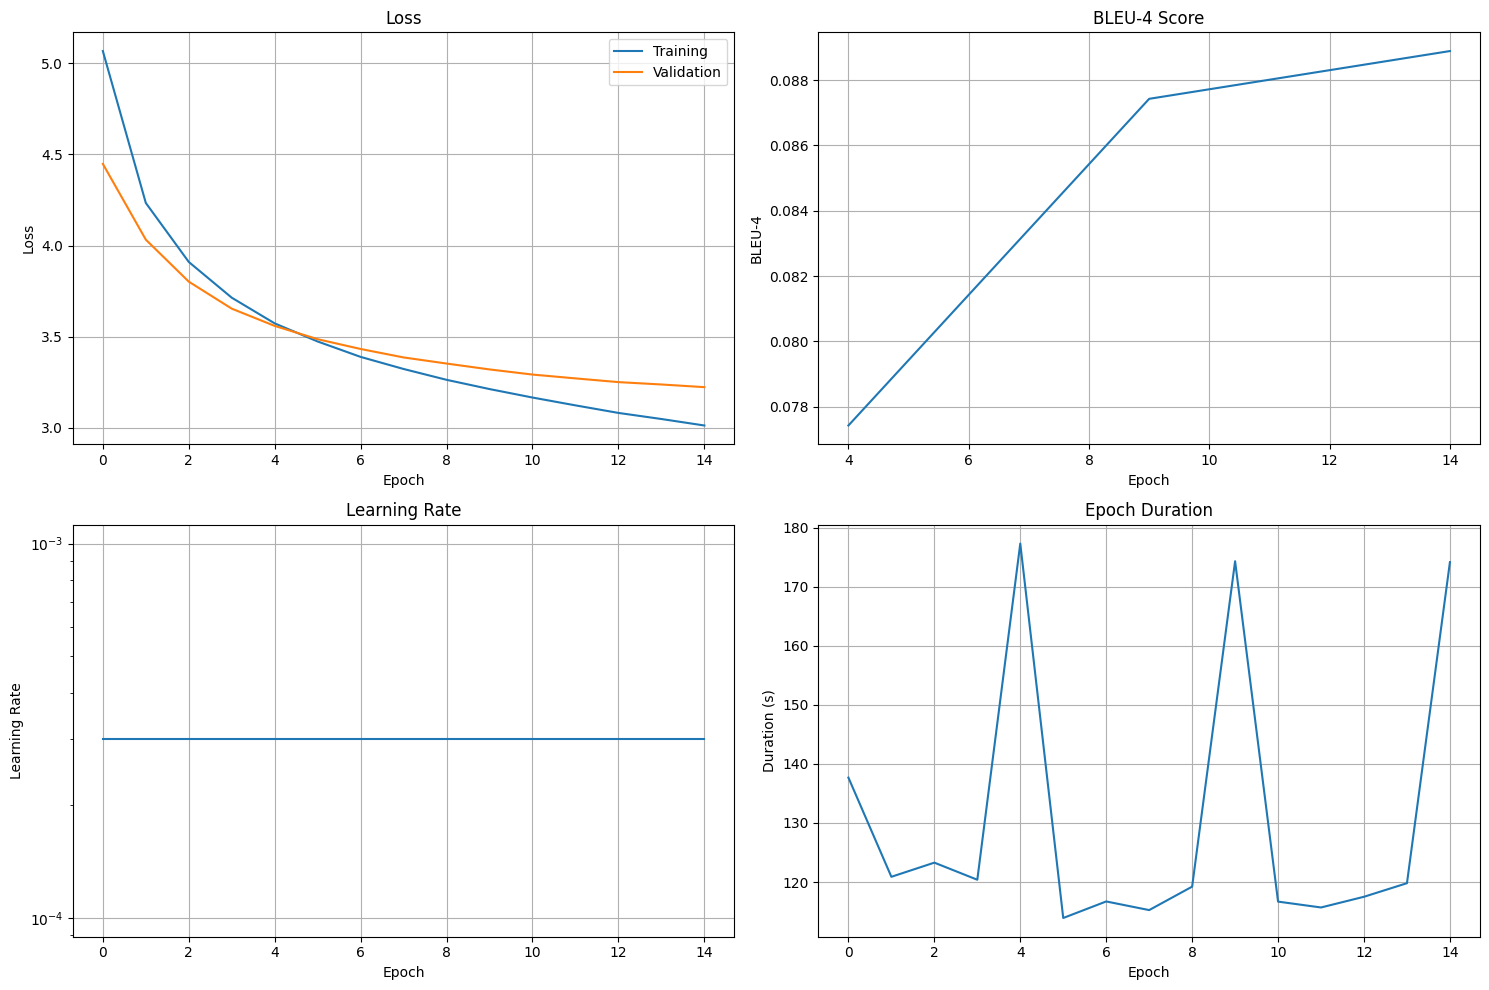

In [18]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

In [19]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 15
Best validation loss: 3.2239
Best BLEU epoch: 15
Best BLEU score: 0.0889


## 6. Generate Sample Captions

In [20]:
# Load the best model
best_model_path = os.path.join(config['save_dir'], 'best_model_loss.pth')
trainer.load_checkpoint(best_model_path)
model = trainer.model.to(config['device'])

Loaded checkpoint from ../models\best_model_loss.pth (epoch 15)


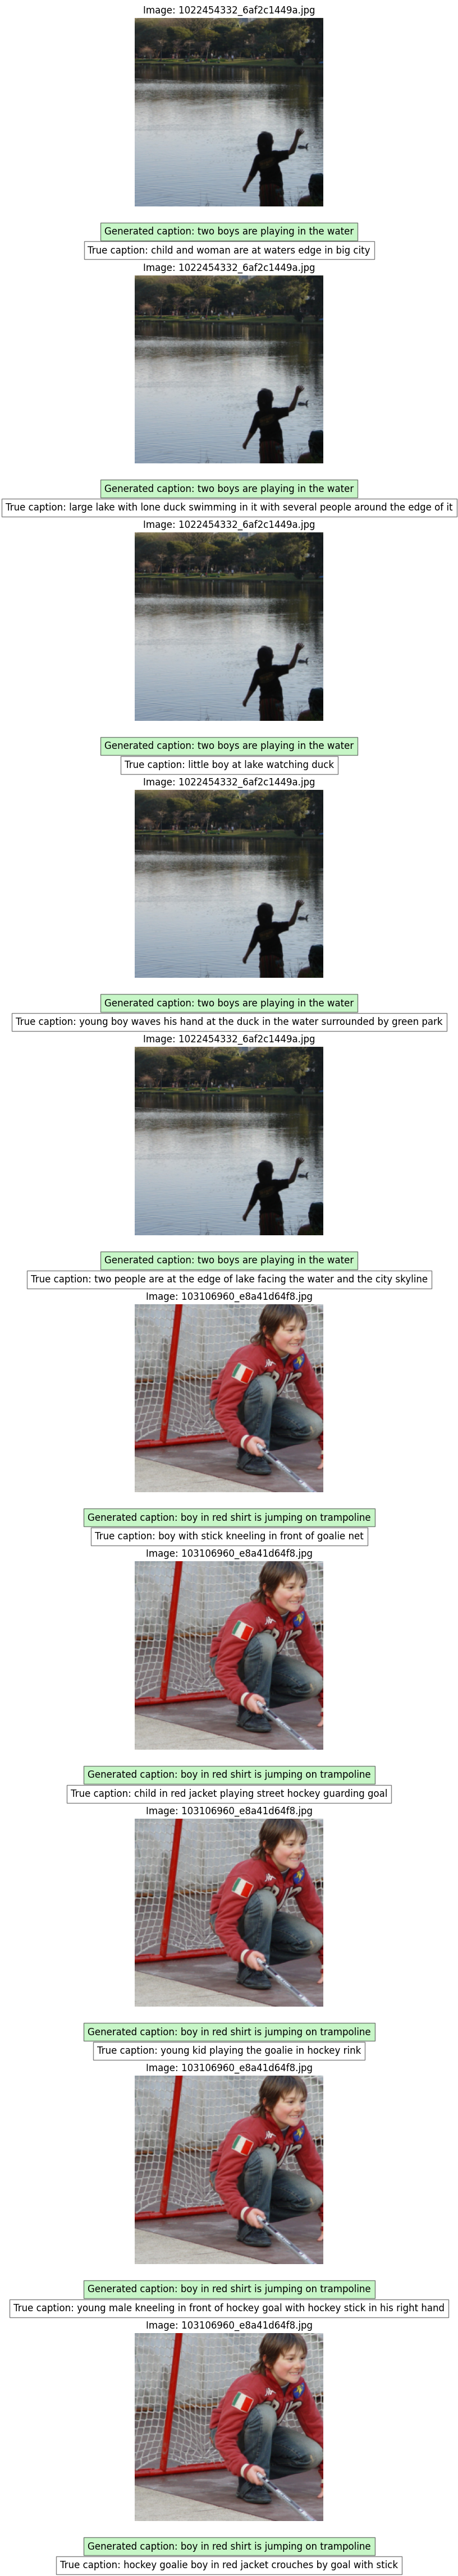

In [23]:
def generate_caption(image, model, vocab, device):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        caption = model.generate_caption(image, max_length=200, beam_size=1)
        # print("Predicted indices:", caption)
        # --- Fix: flatten output if needed ---
        if isinstance(caption, torch.Tensor):
            caption = caption.cpu().numpy().tolist()
        if isinstance(caption, list) and len(caption) > 0 and isinstance(caption[0], list):
            caption = caption[0]
        caption_text = vocab.decode(caption, join=True, remove_special=True)
    return caption_text

# Get some validation examples
num_examples = 10
val_examples = []

for images, captions, image_ids in val_loader:
    if len(val_examples) >= num_examples:
        break

    # Generate captions
    for i in range(len(images)):
        if len(val_examples) >= num_examples:
            break

        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])

        val_examples.append({
            'image': image,
            'image_id': image_ids[i],
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    ax = plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Image: {example['image_id']}")

    # Add captions below image using ax.text
    ax.text(0.5, -0.15, f"Generated caption: {example['generated_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "lightgreen", "alpha": 0.5, "pad": 5})

    ax.text(0.5, -0.25, f"True caption: {example['true_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002196D49D7E0>
Traceback (most recent call last):
  File "c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


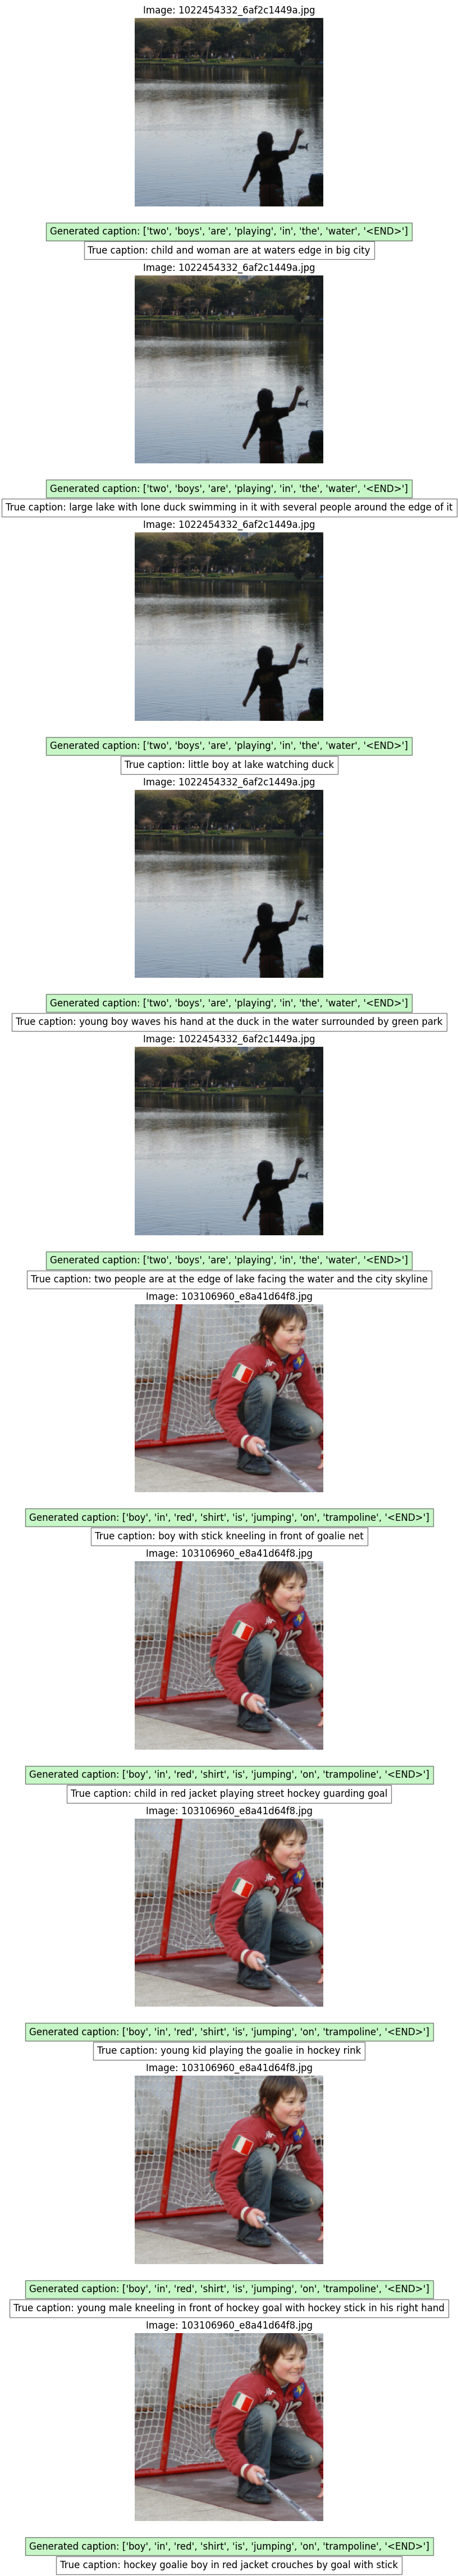

In [28]:
def generate_caption(image, model, vocab, device):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        caption = model.generate_caption(image, max_length=200, beam_size=1)
        print("Predicted indices:", caption)
        # --- Fix: flatten output if needed ---
        if isinstance(caption, torch.Tensor):
            caption = caption.cpu().numpy().tolist()
        if isinstance(caption, list) and len(caption) > 0 and isinstance(caption[0], list):
            caption = caption[0]
        caption_text = vocab.decode(caption)
    return caption_text

# Get some validation examples
num_examples = 10
val_examples = []

for images, captions, image_ids in val_loader:
    if len(val_examples) >= num_examples:
        break

    # Generate captions
    for i in range(len(images)):
        if len(val_examples) >= num_examples:
            break

        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])

        val_examples.append({
            'image': image,
            'image_id': image_ids[i],
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    ax = plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Image: {example['image_id']}")

    # Add captions below image using ax.text
    ax.text(0.5, -0.15, f"Generated caption: {example['generated_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "lightgreen", "alpha": 0.5, "pad": 5})

    ax.text(0.5, -0.25, f"True caption: {example['true_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[13, 97, 17, 34,  4,  5, 24,  2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])
Predicted indices: tensor([[ 16,   4,  25,  36,   7,  45,   6, 371,   2]])


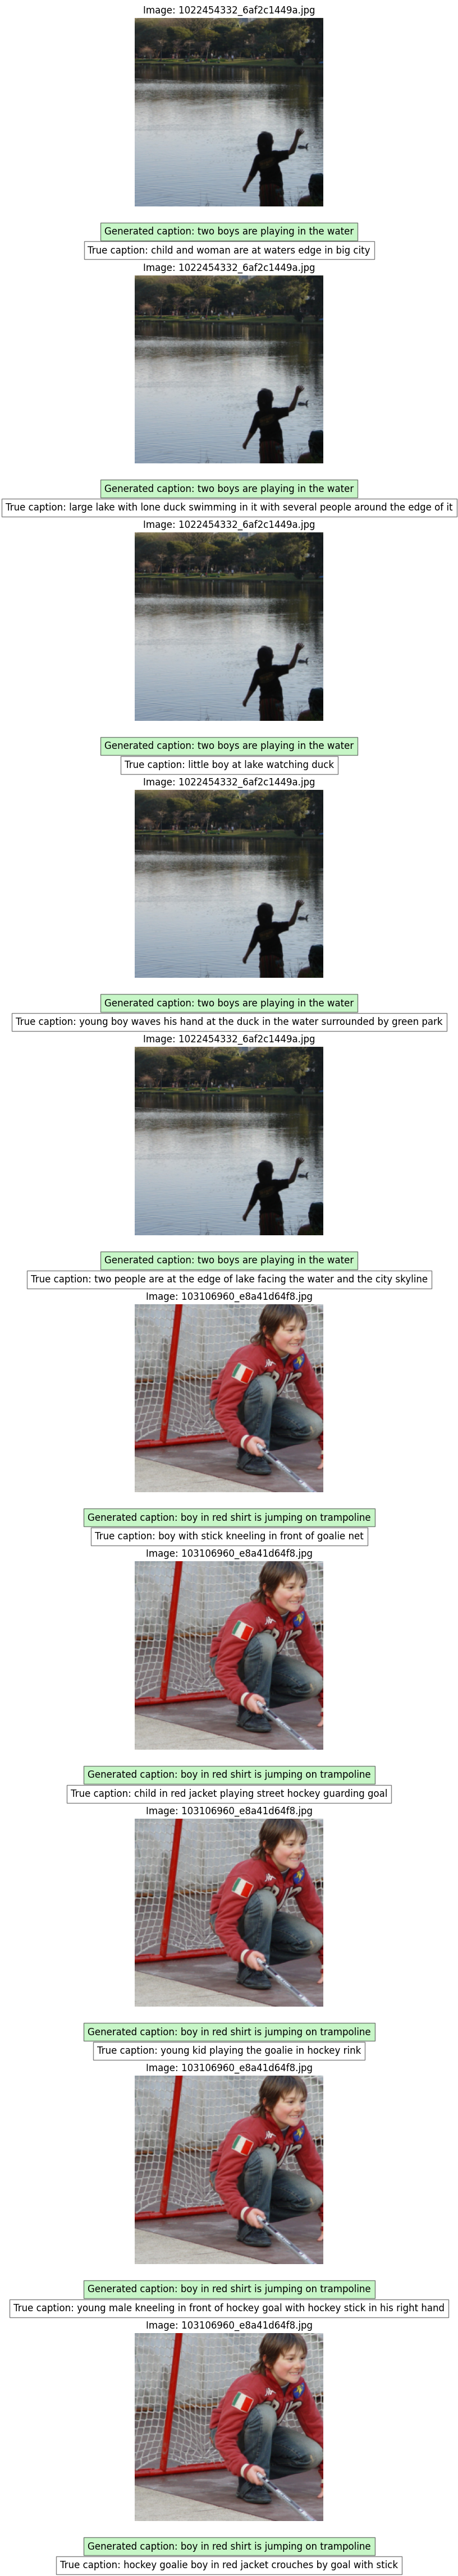

In [24]:
def generate_caption(image, model, vocab, device):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        caption = model.generate_caption(image, max_length=200, beam_size=1)
        print("Predicted indices:", caption)
        # --- Fix: flatten output if needed ---
        if isinstance(caption, torch.Tensor):
            caption = caption.cpu().numpy().tolist()
        if isinstance(caption, list) and len(caption) > 0 and isinstance(caption[0], list):
            caption = caption[0]
        caption_text = vocab.decode(caption, join=True, remove_special=True)
    return caption_text

# Get some validation examples
num_examples = 10
val_examples = []

for images, captions, image_ids in val_loader:
    if len(val_examples) >= num_examples:
        break

    # Generate captions
    for i in range(len(images)):
        if len(val_examples) >= num_examples:
            break

        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])

        val_examples.append({
            'image': image,
            'image_id': image_ids[i],
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    ax = plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Image: {example['image_id']}")

    # Add captions below image using ax.text
    ax.text(0.5, -0.15, f"Generated caption: {example['generated_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "lightgreen", "alpha": 0.5, "pad": 5})

    ax.text(0.5, -0.25, f"True caption: {example['true_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Compare Greedy and Beam Search Decoding

In [31]:
# Define paths
model_dir = '../models'
config_path = os.path.join(model_dir, 'config.json')
model_path = os.path.join(model_dir, 'best_model_loss.pth')  # or 'best_model_bleu.pth'
vocab_path = os.path.join(model_dir, 'vocabulary.pkl')
data_dir = '../data/flickr8k'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

# Print configuration
print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Model configuration:
  data_dir: ../data/flickr8k
  batch_size: 64
  num_workers: 4
  encoder_model: resnet18
  embed_size: 100
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm
  learning_rate: 0.0003
  num_epochs: 15
  early_stopping_patience: 5
  save_dir: ../models
  device: cuda
  vocab_size: 2970


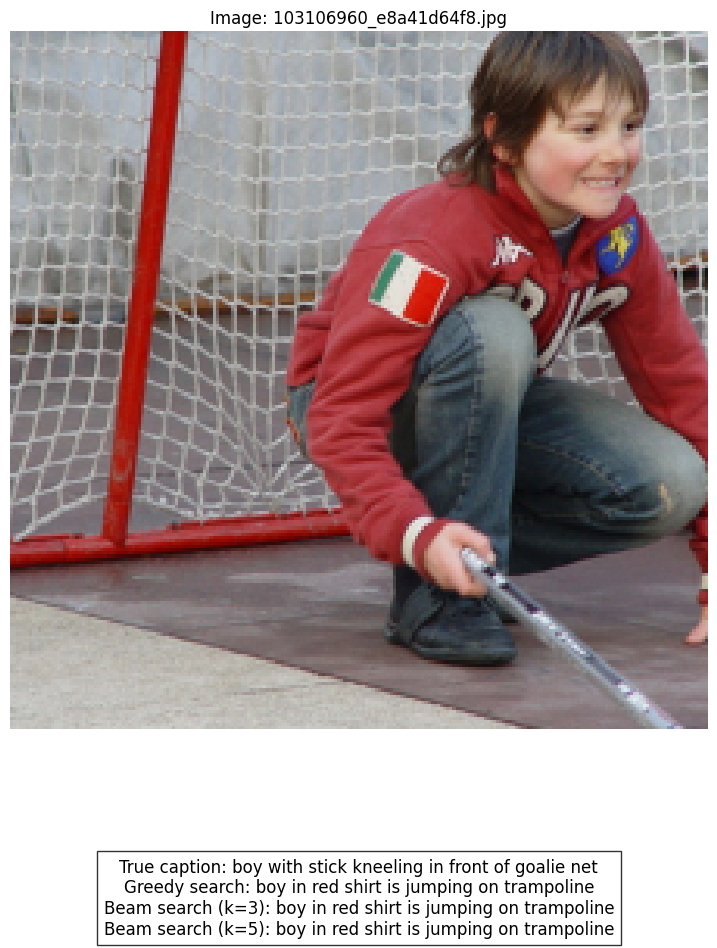

In [49]:
def compare_decoding_methods(image, model, vocab, device, beam_sizes=[1, 3, 5]):
    """Compare different beam search sizes for caption generation."""
    # ✅TODO: Implement a function to compare different beam search settings
    # 1. Set the model to evaluation mode
    model.eval()

    # 2. Initialize a dictionary to store results
    results = {}

    # 3. For each beam size:
    with torch.no_grad():
        for beam_size in beam_sizes:
            try:
                # a. Generate a caption using that beam size
                caption_indices = model.generate_caption(image.unsqueeze(0).to(device), beam_size=beam_size)
            except AttributeError:
                # If we get an AttributeError, it means caption_indices is already a list
                pass

            # Convert tensor to list if needed and handle nested lists
            if isinstance(caption_indices, torch.Tensor):
                caption_indices = caption_indices.cpu().numpy().tolist()
            
            # Flatten the list if it's nested
            if isinstance(caption_indices, list) and isinstance(caption_indices[0], list):
                caption_indices = caption_indices[0]

            caption_words = [
                vocab.idx2word[idx]
                for idx in caption_indices
                if idx not in {
                    vocab.word2idx['<START>'], 
                    vocab.word2idx['<END>'], 
                    vocab.word2idx['<PAD>']
                }
            ]

            caption_text = ' '.join(caption_words)

            #    c. Store the result in the dictionary
            results[f'beam_{beam_size}'] = caption_text

    # 4. Return the dictionary of results
    return results

# Select a random example from val_examples
import random
example = random.choice(val_examples)

# Compare decoding methods
beam_results = compare_decoding_methods(
    example['image'], 
    model, 
    vocab, 
    config['device'], 
    beam_sizes=[1, 3, 5]
)

# Display the image with different captions
plt.figure(figsize=(10, 10))

# Display image
img = example['image'].permute(1, 2, 0).numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {example['image_id']}")

# Add captions
captions = [
    f"True caption: {example['true_caption']}",
    f"Greedy search: {beam_results['beam_1']}",
    f"Beam search (k=3): {beam_results['beam_3']}",
    f"Beam search (k=5): {beam_results['beam_5']}"
]

# Display captions below the image
plt.figtext(0.5, 0.01, '\n'.join(captions), ha='center', fontsize=12, 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()

## 8. Save Final Model and Configuration

In [25]:
# Save configuration
import json
config_path = os.path.join(config['save_dir'], 'config.json')

# Convert non-serializable values to strings
serializable_config = {k: str(v) if not isinstance(v, (int, float, str, bool)) else v 
                      for k, v in config.items()}

with open(config_path, 'w') as f:
    json.dump(serializable_config, f, indent=4)

print(f"Configuration saved to {config_path}")

Configuration saved to ../models\config.json


In [26]:
# Save vocabulary separately for easy access
import pickle
vocab_path = os.path.join(config['save_dir'], 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Vocabulary saved to {vocab_path}")

Vocabulary saved to ../models\vocabulary.pkl


## Summary

In this notebook, we have successfully:

1. Set up the data loaders for training and validation
2. Built the caption model by combining the encoder and decoder
3. Trained the model with teacher forcing
4. Monitored the training progress and validation performance
5. Generated captions for sample images
6. Compared different decoding strategies (greedy vs. beam search)
7. Saved the model, configuration, and vocabulary for later use

In the next notebook, we will perform a comprehensive evaluation of the model on the test set.